In [2]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
data_tr=scipy.io.loadmat('data_train.mat')
data_te=scipy.io.loadmat('data_test.mat')
label_tr=scipy.io.loadmat('label_train.mat')

print(data_tr.keys())
X=data_tr['data_train']
print(X.shape)

print(label_tr.keys())
y=label_tr['label_train']
print(y.shape)

##judge the distribution of labels
np.unique(y)


dict_keys(['__header__', '__version__', '__globals__', 'data_train'])
(301, 33)
dict_keys(['__header__', '__version__', '__globals__', 'label_train'])
(301, 1)


array([-1,  1], dtype=int16)

## Input Layer
Since the train data have 33 features, the input layer should have 33 neurons.

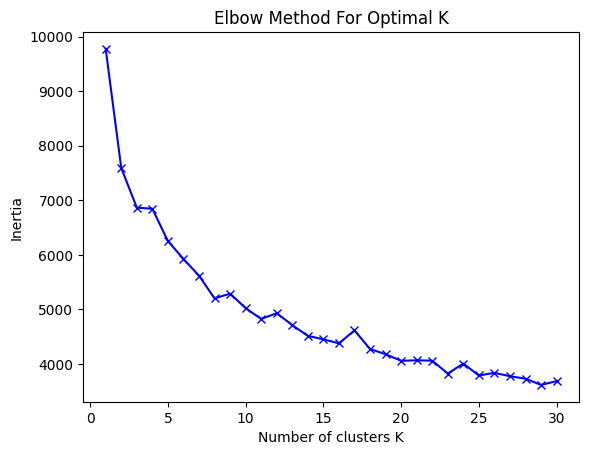

In [17]:
## Neuron centres selection
## Kmeans method
class ncs_Kmeans:
    def __init__ (self, X, n_clusters, max_iters=10000):
        ##standerlize
        self.X=(X-X.mean(axis=0))/X.std(axis=0)
        self.n_clusters=n_clusters
        self.max_iters=max_iters
        self.n_samples, n_features=X.shape

    def distance(self, a, b):
        return np.linalg.norm(a-b, axis=1)
    
    def fit(self):
        ##randomly select initial centres
        random_indices=np.random.choice(self.n_samples, self.n_clusters, replace=False)
        self.centres=self.X[random_indices]

        for _ in range(self.max_iters):
            #assign clusters
            clusters=[]
            for x in self.X:
                distances=self.distance(x, self.centres)
                cluster=np.argmin(distances)
                clusters.append(cluster)
            clusters=np.array(clusters)

            #update centres
            new_centres=[]
            for i in range(self.n_clusters):
                points=self.X[clusters==i]
                new_centre=points.mean(axis=0)
                new_centres.append(new_centre)
            new_centres=np.array(new_centres)

            #check convergence
            if np.all(self.centres==new_centres):
                break
            self.centres=new_centres

        self.clusters=clusters
        return self.centres, self.clusters
## elbow method to select number of clusters  
inertias=[]
K=range(1,31)
for k in K:
    kmeans=ncs_Kmeans(X, n_clusters=k)
    centres, clusters=kmeans.fit()
    inertia=0
    for i in range(k):
        points=X[clusters==i]
        inertia+=np.sum((points - centres[i])**2)
    inertias.append(inertia)
plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of clusters K')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.show()

In [29]:
##select k=8
kmeans=ncs_Kmeans(X, n_clusters=8)
centres, clusters=kmeans.fit()
print("Centres shape:", centres.shape)

def distance(a,b):
    return np.linalg.norm(a-b)

class RBFNN:
    def __init__(self, X, centres, sigma):
        self.X=X
        self.centres=centres
        self.sigma=sigma
        self.n_centres=centres.shape[0]
    
    def gaussian_rbf(self,x,centre):
        return np.exp(-np.linalg.norm(x-centre)**2/(2*self.sigma**2))
    
    def hidden_layer_activation(self):
        n_samples=self.X.shape[0]
        H=np.zeros((n_samples, self.n_centres))
        for i in range(n_samples):
            for j in range(self.n_centres):
                H[i,j]=self.gaussian_rbf(self.X[i], self.centres[j])
        return H
    
    def train(self,y):
        H=self.hidden_layer_activation()
        H_bias=np.hstack((np.ones((H.shape[0],1)), H))
        self.weights=np.linalg.pinv(H_bias).dot(y)

    def predict(self, X_test):
        n_samples=X_test.shape[0]
        H_test=np.zeros((n_samples, self.n_centres))
        for i in range(n_samples):
            for j in range(self.n_centres):
                H_test[i,j]=self.gaussian_rbf(X_test[i], self.centres[j])
        H_test_bias=np.hstack((np.ones((H_test.shape[0],1)), H_test))
        y_pred=H_test_bias.dot(self.weights)
        return y_pred

##compute sigma with d_{max}/sqrt(2*n_centres)
d_max=0
for i in range(centres.shape[0]):
    for j in range(i+1, centres.shape[0]):
        d=distance(centres[i], centres[j])
        if d>d_max:
            d_max=d
sigma=d_max/np.sqrt(2*centres.shape[0])
print("Sigma:", sigma)
rbfnn=RBFNN(X, centres, sigma)
rbfnn.train(y)
X_test=data_te['data_test']
y_pred=rbfnn.predict(X_test)

np.unique(y_pred, return_counts=True)



Centres shape: (8, 33)
Sigma: 2.6019639471989895


(array([-0.78588928, -0.78352655, -0.78300741, -0.78196231, -0.77833408,
        -0.77708205, -0.77677801, -0.77251266, -0.75720915, -0.75571022,
        -0.72669308, -0.58306407, -0.56711053, -0.47989994, -0.46529108,
        -0.34031547, -0.30716963, -0.0588739 , -0.04253602, -0.02962741,
        -0.01206894,  0.01340039,  0.10244002,  0.13340653,  0.22868034,
         0.36679156,  0.4490951 ,  0.46983669,  0.47466669,  0.51597366,
         0.63136262,  0.63401731,  0.65823122,  0.81776413,  0.89471727,
         0.92055396,  0.92718247,  0.97320236,  1.01576675,  1.06309715,
         1.09894537,  1.11041556,  1.14691573,  1.18456425,  1.23228082,
         1.24033099,  1.2747467 ,  1.27920297,  1.3004959 ,  1.64706494]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1]))